# Baysian estimation of a harmonic oscillator

These are general definitions to be included in all `bayesian-ex*` notbooks (done via including the identical `../bayesian-example-base.jl` file.

This describes the

- forward model
- probabilistic model: likelihood, priors
- some helpers, such as plotting

In [1]:
# Bookkeeping
using KissMCMC
using StatsBase
using ODE
import Compat.view
if VERSION<v"0.5-"
    eval(:(using FastAnonymous))
else
    macro anon(args)
        args
    end
end

## Deterministic forward model: harmonic oscillator

$ẍ = - ω² x$

with initial condition (IC): $x(0) = x0, v(0) = v0$

Thus the model has three parameter (A, ω, ϕ) amplitude, circular frequency and phase (or equivalently ω, x0, v0).

Note that there is a similar example here: https://github.com/QuantifyingUncertainty/GMHExamples.jl/blob/master/ode/notebooks/SpringMass1.ipynb

In [2]:

"The differential equations of the forward model.  To be used with ODE.jl."
function odes(t,y,ω)
    x = y[1]
    v = y[2]
    return [v, -ω^2*x]
end
"The analytic solution of the forward model"
function asol(t,A,ω,ϕ) # amplitude, circular frequency and phase
    x =   A*sin(ω*t + ϕ)
    v = ω*A*cos(ω*t + ϕ)
    return x,v
end

"""
The forward model using the analytic solution (faster).

Input:
- out -- in-place output array
- theta - parameters (ts,A,ω,ϕ)

Output:
- out
"""
function _fwd_ana!(out,ts,A,ω,ϕ)
    for (i,t) in enumerate(ts)
        out[2i-1],out[2i] = asol(t,A,ω,ϕ)
    end
    return out
end

# Using @anon should make it faster on Julia-0.4
fwd_ana! = @anon (out,ts,A,ω,ϕ) -> _fwd_ana!(out,ts,A,ω,ϕ)
fwd_ana = (ts,A,ω,ϕ) -> (out=init_fwd(ts); _fwd_ana!(out,ts,A,ω,ϕ); out)


"""

The forward model using an ODE solver.  This is much slower than using
the analytic solution but more representative of a "real" case.

Input:
- out -- in-place output (the MCMC samplers require this)
- ts,A,ω,ϕ - parameters

Output:
- out
"""
function fwd_ode!(out,ts,A,ω,ϕ)
    # make ICs from parameters:
    x0,y0 = asol(0,A,ω,ϕ)
    f = (t,y) -> odes(t,y,ω)
    tout,yout = ode45(f, [x0,y0], ts,
                      points=:specified,
                      reltol=1e-4,
                      abstol=1e-5)
    for (i,y) in enumerate(yout)
        out[2i-1] = y[1]
        out[2i] = y[2]
    end
    return out
end
fwd_ode = (ts,A,ω,ϕ) -> (out=init_fwd(ts); fwd_ode!(out,ts,A,ω,ϕ); out)

"Initialize in-place output array, and length for fwd-paras."
init_fwd(ts) = zeros(2*length(ts));

## Probabilistic model

Define a function to quantify a model vs measurements error. The standard is to assume a normal distributed mean square error.

In [3]:
"Square error of one observation."
err1(y_measured, y_modelled) = (y_measured-y_modelled)^2


"""
Log-Likelihood for given input xv_measured and given forward model result.

This assumes that the errors have a normal distribution with std-dev
sigma.

Input
- fwdout -- result vector of forward model
- xv_measured -- observation (x,v) points
- sigma -- assumed std-dev of errors.  Can be a fitting parameter.

Output:
- likelihood
"""
function loglikelihood(fwdout, xv_measured, sigma)
    out = zero(err1(xv_measured[1], fwdout[1]))
    N = length(xv_measured)
    for i=1:N
        # Note the normalization term 1/2*log(2*pi*sigma^2) needs to
        # be included when sigma is also a fitting parameter.
        out -= err1(xv_measured[i], fwdout[i])/(sigma^2) + log(2*pi*sigma^2)
    end
    return out/2
end
function loglikelihood(fwdout, xv_measured, sigma::AbstractVector)
    out = zero(err1(xv_measured[1], fwdout[1]))
    N = length(xv_measured)
    for i=1:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma[i]^2)  + log(sqrt(2*pi*sigma[i]^2))
    end
    return out/2
end

"""
Log-Likelihood of a set of parameters for a forward model and for
given input xv_measured.  To be defined.

Should probably have a signature:
loglikelihood!(theta)

Modifies fwdout in-place
"""
function loglikelihood! end

# """
# Draw a sample model-state from the likelihood for given parameters
# theta at indices in fwdout_inds_pred.

# Note: the fwdout_inds_pred vector passed into this function is likely
# different to the one fwdout_inds passed into loglikelihood!.
# """
# function sample_likelihood(fwdout, fwdout_inds_pred, theta, sigma)
#     randn(length(fwdout[fwdout_inds_pred])).*sigma  + fwdout[fwdout_inds_pred]
# end
# function sample_likelihood(fwdout, fwdout_inds_pred, theta, sigma::AbstractVector)
#     randn(length(fwdout[fwdout_inds_pred])).*sigma[fwdout_inds_pred]  + fwdout[fwdout_inds_pred]
#end

## Priors

In the end I need a `pdf(theta)`.  For ease, assume that the prior for each parameter is independent.

In [4]:
# suggested priors:
function logprior_A end
function logprior_ω end
function logprior_ϕ end
function logprior_ts end # sum of all ts priors
function logprior_sigma end  # sum of all sigma priors

# """
# Log-prior function

# Input:

# - parameters
# - fixed parameters

# Output
# - log(prior)
# """
# Suggested form:
# logprior = @anon (thetas, N_fwd) -> (logprior_A(thetas[1]) + logprior_ω(thetas[2]) +
#                                      logprior_ϕ(thetas[3]) + logprior_ts(thetas[4:N_fwd]) +
#                                      logprior_sigma(thetas[N_fwd+1:length(thetas)]))

logprior_sigma (generic function with 0 methods)

## Synthetic measurements

In [9]:
"""
Produce the synthetic xv_measured by running the forward model and adding noise.

Input:
    ts = 0:0.25:10, # time steps at which measurements are (supposed to be) taken
    theta_true = [2.3, 7/pi, pi/7], # [A, ω, ϕ]
    sigma_x = 0.3 # std deviations of measurement errors of x
    sigma_v = 0.3 # std deviations of measurement errors of v
    sigma_t = 0.1 # std deviation of time errors

Output:
- ts, xv_measured -- the measured xv_measured: measurement times and values
- ts_true, xv_true  -- the true values of the system at the true measurement time
"""
function make_synthetic_measurements(;ts = 0.0:10.0, # time steps at which measurements are taken
                   theta_true = [2.5, 1.1, 3], # [A, ω, ϕ]
                   sigma_x = 0.3, # std deviation of measurement errors of x
                   sigma_v = 0.2, # std deviation of measurement errors of v
                   sigma_t = 0.0 # std deviation of time errors
                   )
    ns = length(ts)
    # add noise to the times:
    ts_true = ts + randn(ns)*sigma_t
    xv_true = fwd_ana(ts_true, theta_true...)
    xs = xv_true[1:2:end]
    vs = xv_true[2:2:end]

    # add noise
    x_measured = xs + sigma_x*randn(ns)
    v_measured = vs + sigma_v*randn(ns)
    xv_measured = hcat(x_measured ,v_measured)'[:]
    A, ω, ϕ = theta_true
    return ts, xv_measured, A, ω, ϕ, ts_true, xv_true
end;

## Plotting and other helpers

In [10]:
"Unpack a staggered (x,v) vector as returned by the forwardmodel"
unpack_xv(xv::Vector) = (xv[1:2:end], xv[2:2:end])
unpack_xv(xv::Matrix) = (xv[1:2:end,:], xv[2:2:end,:])

"Plots the true solution and the noisy synthetic measurements.  Errorbars are two sigma."
function plotmeasurements(ts_measured, xv_measured, A, ω, ϕ; sigma_x=0.0, sigma_v=0.0, sigma_t=0.0)
    x_measured,v_measured = unpack_xv(xv_measured)
    t_plot = ts_measured[1]:0.01:ts_measured[end]
    x_plot,v_plot = asol(t_plot,A,ω,ϕ)
    p1 = plot(t_plot, x_plot, label="x", ylabel="x")
    scatter!(ts_measured, x_measured, markercolor=:blue,label="x measured", xerr=2*sigma_t, yerr=2*sigma_x)
    p2 = plot(t_plot, v_plot, label="v", ylabel="v", xlabel="t")
    scatter!(ts_measured, v_measured, markercolor=:green,label="v measured", xerr=2*sigma_t, yerr=2*sigma_v)
    xlims!((0,10))
    plot(p1,p2,layout=(2,1),link=:x)
end

"Plots the true trajectory, measurments and predictions"
function plot_violin(ts_measured, xv_measured, ts_pred, xv_a, xv_b, A, ω, ϕ;
                     sigma_x=0.0, sigma_v=0.0, sigma_t=0.0, t_plot=nothing, pred_inds=nothing,
                     pred_inds_sep=nothing, ylims=(-4.5,4.5), size=(600,300))


    x_measured,v_measured = unpack_xv(xv_measured)
    x_a,v_a = unpack_xv(xv_a)
    x_b,v_b = unpack_xv(xv_b)
    if pred_inds==nothing
        pred_inds = 1:length(ts_pred)
    end
    if t_plot==nothing
        t_plot = min(ts_mebsured[1],ts_pred[1]):0.01:max(ts_pred[end],ts_measured[end])
    end
    x_plot,v_plot = asol(t_plot,A,ω,ϕ)
    p1 = plot(t_plot, x_plot, label="x", ylabel="x")
    scatter!(ts_measured, x_measured, markercolor=:blue,label="x measured", xerr=2*sigma_t, yerr=2*sigma_x)
    # violins, see https://github.com/tbreloff/Plots.jl/pull/339
    violin!(ts_pred[pred_inds], vec(x_a[pred_inds,:]),alpha=0.3, label="prediction (a)")
    violin!(ts_pred[pred_inds], vec(x_b[pred_inds,:]),alpha=0.3, label="prediction (b)")
    ylims!(ylims)

    p2 = plot(t_plot, v_plot, label="v", ylabel="v", xlabel="t")
    scatter!(ts_measured, v_measured, markercolor=:green,label="v measured", xerr=2*sigma_t, yerr=2*sigma_v)
    violin!(ts_pred[pred_inds], vec(v_a[pred_inds,:]),alpha=0.3, label="prediction (a)")
    violin!(ts_pred[pred_inds], vec(v_b[pred_inds,:]),alpha=0.3, label="prediction (a)")
    ylims!(ylims)

    if pred_inds_sep==nothing
        plot(p1,p2,layout=(2,1))
    else
        ps = [p1,p2]
        for i in pred_inds_sep
            tp = ts_pred[i]
            t_plot = tp-.6:0.01:tp+.6
            x_plot,v_plot = asol(t_plot,A,ω,ϕ)
            push!(ps, plot(t_plot, x_plot, label="x", ylabel="x"))
            violin!(ts_pred[i:i], vec(x_a[i,:]),alpha=0.3, label="prediction (a)")
            violin!(ts_pred[i:i], vec(x_b[i,:]),alpha=0.3, label="prediction (b)",
                    legend=false)
            ylims!(ylims)

            push!(ps, plot(t_plot, v_plot, label="v", ylabel="v"))
            violin!(ts_pred[i:i], vec(v_a[i,:]),alpha=0.3, label="prediction (a)")
            violin!(ts_pred[i:i], vec(v_b[i,:]),alpha=0.3, label="prediction (b)",
                    legend=false)
            ylims!(ylims)
        end
        # resorting:
        ps = reshape(ps,2,length(ps)÷2)'
        ps = ps[:]
        ne = length(pred_inds_sep)
        widths = vcat(0.6, 0.4/ne*ones(ne))
        plot(ps...,layout=grid(2,length(ps)÷2, widths=widths), size=size)
    end
end

plot_violin (generic function with 1 method)

[Plots.jl] Initializing backend: pyplot



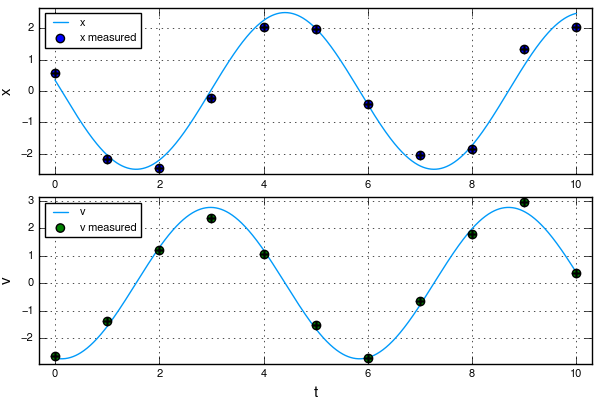

In [11]:
using Plots
ts_measured, xv_measured, A, ω, ϕ, ts_true, xv_true = make_synthetic_measurements()
plotmeasurements(ts_measured,xv_measured,A,ω,ϕ)

Plot of the position `x` and velocity `v` of the harmonic oscillator.  Dots are the synthetic measurments.